In [1]:
# 引入库
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
import re
import jieba  
import shap  
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.feature_extraction.text import TfidfVectorizer  

In [ ]:
# 转换为csv文件
data = pd.read_excel('data/data.xlsx')
data.to_csv('data.csv', index=False)
data = pd.read_excel('new_data.xlsx')
data.to_csv('new_data.csv', index=False)
data = pd.read_excel('tag_count.xlsx')
data.to_csv('tag_count.csv', index=False)

In [ ]:
# 转换标签列表为以空格间隔的字符串
import csv
import ast  

with open('data.csv', newline='', encoding='utf-8') as infile:
    reader = csv.reader(infile)
    rows = []
    
    for row in reader:
        new_row = []
        for item in row:
            if item.startswith('[') and item.endswith(']'):
                try:
                    item_list = ast.literal_eval(item)
                    new_item = ' '.join(item_list)
                    new_row.append(new_item)
                except Exception as e:
                    new_row.append(item)
            else:
                new_row.append(item)
        rows.append(new_row)
with open('output.csv', mode='w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerows(rows)
print("done！")


In [ ]:
# 读取文件
df = pd.ExcelFile('data.xlsx')
df = df.parse('Sheet1')

## 2.4.2 热门标签分析

In [ ]:
# 前10热门标签
all_tags = []
for tags in df['标签']:
    tags_str = tags.replace("[", "").replace("]", "").replace("'", "").strip()
    tags_list = tags_str.split(', ')
    all_tags.extend(tags_list)
tag_counts = pd.Series(all_tags).value_counts()
top_five_tags = tag_counts.head(10)
print(top_five_tags)
# plt设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.bar(top_five_tags.index, top_five_tags.values)
plt.xlabel('标签')
plt.ylabel('出现次数')
plt.title('前十个热门标签柱状图')
plt.show()

In [ ]:
# 存表tag_count
df_tag = pd.DataFrame(all_tags, columns=['tag'])
count_result = df_tag['tag'].value_counts().reset_index()
count_result.columns = ['标签', '出现次数']
count_result.to_excel('tag_count.xlsx', index=False)

In [ ]:
# 存表type_count
all_type = []
for type in df['类型']:
    type_str = type.split('-')
    all_type.extend(type_str)
df_type = pd.DataFrame(all_type, columns=['type'])
count_result = df_type['type'].value_counts().reset_index()
count_result.columns = ['类型', '出现次数']
count_result.to_excel('type_count.xlsx', index=False)

## 2.4.5 关联规则分析小说类型与品质

In [ ]:
# “品质”列添加
data = pd.DataFrame(df['类型'], columns=['类型'])
quality_list = ['优秀'] * 100 + ['良好'] * 100
data['品质'] = quality_list
data.to_excel("rule.xlsx", index=False)

In [ ]:
# apriori分析
analy_df = pd.read_excel("rule.xlsx")
te = TransactionEncoder()
te_ary = te.fit(analy_df[['类型','品质']].values).transform(analy_df[['类型','品质']].values)
analy_df_encoded = pd.DataFrame(te_ary, columns = te.columns_)
frequent_itemsets = apriori(analy_df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.01,num_itemsets=200)
with pd.ExcelWriter('apriori_rule.xlsx') as writer:
    frequent_itemsets.to_excel(writer, index=False)
    rules.to_excel(writer, index=False)

In [ ]:
# 数据格式清洗
data = pd.read_excel("apriori_rule.xlsx")
list1 = data['consequents']
list2 = data['antecedents']
new1 = []
new2 = []
for element in list1:
    match = re.search(r'\{([^}]*)\}', element)
    if match:
        new_content = match.group(1).replace("'", "").replace(", ", "，")
        new1.append(new_content)
for element in list2:
    match = re.search(r'\{([^}]*)\}', element)
    if match:
        new_content = match.group(1).replace("'", "").replace(", ", "，")
        new2.append(new_content)
data['consequents'] = new1
data['antecedents'] = new2
data.to_excel("apriori_rule.xlsx", index=False)

In [ ]:
# 数据分析过滤
data = pd.read_excel("apriori_rule.xlsx")
filtered_data = data[data['consequents'].isin(['优秀', '良好'])]
filtered_data.to_excel('apriori_rule.xlsx', index=False)

## 2.4.6 SHAP特征重要性分析

In [ ]:
# 分词预处理
df = pd.read_csv('output.csv')  
def preprocess_text(text):  
    if pd.isna(text):  
        return ''  
    return ' '.join(jieba.cut(text))   

for col in ['书名', '作者', '类型', '标签']:  
    df[col] = df[col].apply(preprocess_text)  

df['text_combined'] = df[['书名', '作者', '类型', '标签']].agg(' '.join, axis=1)  

tfidf_vectorizer = TfidfVectorizer()  
X = tfidf_vectorizer.fit_transform(df['text_combined'])  
y = df['积分']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [9]:
# 随机森林回归训练模型  
model = RandomForestRegressor(n_estimators=100, random_state=42)  
model.fit(X_train, y_train)   
# SHAP分析  
explainer = shap.TreeExplainer(model)  
X_test_dense = X_test.toarray() 
shap_values = explainer.shap_values(X_test_dense)  
shap_abs_mean = np.abs(shap_values).mean(axis=0) 

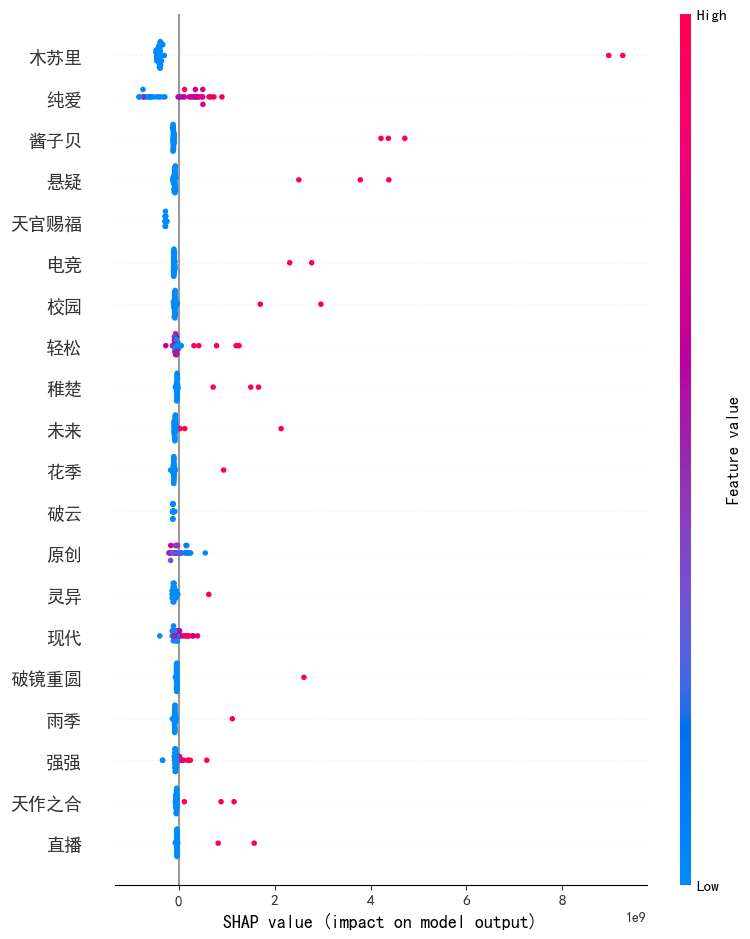

In [10]:
top_feature_indices = np.argsort(shap_abs_mean)
# 可视化

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   

shap.summary_plot(shap_values[:, top_feature_indices],   
                  X_test_dense[:, top_feature_indices],   
                  feature_names=np.array(tfidf_vectorizer.get_feature_names_out())[top_feature_indices],  
                )  # set show=False to avoid immediate plot display  


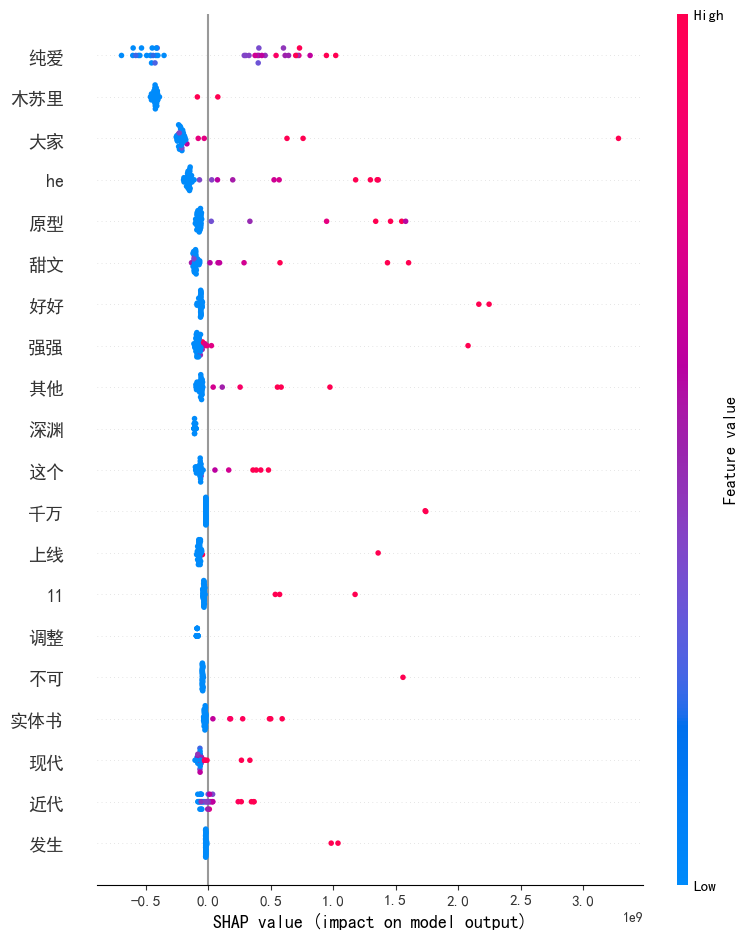

In [ ]:
# 分词预处理
df = pd.read_csv('output.csv')  
def preprocess_text(text):  
    if pd.isna(text):  
        return ''  
    return ' '.join(jieba.cut(text))   

for col in ['书名', '作者', '类型', '标签','简介']:  
    df[col] = df[col].apply(preprocess_text)  

df['text_combined'] = df[['书名', '作者', '类型', '标签','简介']].agg(' '.join, axis=1)  

tfidf_vectorizer = TfidfVectorizer()  
X = tfidf_vectorizer.fit_transform(df['text_combined'])  
y = df['积分']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

model = RandomForestRegressor(n_estimators=100, random_state=42)  
model.fit(X_train, y_train)   
# SHAP分析  
explainer = shap.TreeExplainer(model)  
X_test_dense = X_test.toarray() 
shap_values = explainer.shap_values(X_test_dense)  
shap_abs_mean = np.abs(shap_values).mean(axis=0) 
top_feature_indices = np.argsort(shap_abs_mean)

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   

shap.summary_plot(shap_values[:, top_feature_indices],   
                  X_test_dense[:, top_feature_indices],   
                  feature_names=np.array(tfidf_vectorizer.get_feature_names_out())[top_feature_indices],  
                )  # set show=False to avoid immediate plot display  
